## Introduction to Object Detection using Deep Learning - Mini Project
---
Instructions are given in <span style="color:blue">blue</span> color.

<span style="color:blue">As a starting point, use</span>
* the [implementation notebook](07a_Intro_OD_PT.ipynb) and rename it to `<your initials>_Intro_OD_MD.ipynb`
* and the [script containing the utility functions](utils.py) renamed to `<your initials>_utils_MD.py`

(and then <span style="color:blue">be sure to import from the new utils</span> in your notebook).

**General Instructions and Hints**

* <span style="color:blue"> In your solution notebook and in the <tt>utils</tt> script, make it clear and explain what you did for which one of the tasks using markdown and / or commentary as appropriate.</span>
* You can delete most of the markdown from the original notebook and keep only what you reference for your solutions, but add explanations where necessary yourself.
* You will be able to make use of or at least be inspired by some of the material already provided for other topics in this class (e.g., for Task 1.4)
* <span style="color:red"> Whenever you use something from a specific source or by employing a specific tool <b>academic honesty demands</b> that you reference the original source!!!</span>

## Overview
- [Introduction to Object Detection using Deep Learning - Mini Project](#Introduction-to-Object-Detection-using-Deep-Learning---Mini-Project)
- [Task 1: Minor Modifications and Additions to the SSD implementation](#Task-1:-Minor-Modifications-and-Additions-to-the-SSD-implementation)
  - [Task 1.1: Provide Information on the CUDA device](#Task-1.1:-Provide-Information-on-the-CUDA-device)
  - [Task 1.2: Ensure reproducibility](#Task-1.2:-Ensure-reproducibility)
  - [Task 1.3: Use epochs instead of iterations](#Task-1.3:-Use-epochs-instead-of-iterations)
  - [Task 1.4: Additions to the color mapping](#Task-1.4:-Additions-to-the-color-mapping)
  - [Task 1.5: Selective saving of checkpoints](#Task-1.5:-Selective-saving-of-checkpoints)
- [Task 2: Advanced Modifications and Additions](#Task-2:-Advanced-Modifications-and-Additions)
  - [Task 2.1: History](#Task-2.1:-History)
  - [Task 2.2: Advanced saving of checkpoints](#Task-2.2:-Advanced-saving-of-checkpoints)
  - [Task 2.3: Visual checking of progress](#Task-2.3:-Visual-checking-of-progress)
- [Additional Ideas](#Additional-Ideas)
- [Extra Credit](#Extra-Credit)

---

## Task 1: Minor Modifications and Additions to the SSD implementation
In the first part of the mini project, you will be asked to apply some minor changes and provide simple additions to the SSD implementation.

### Task 1.1: Provide Information on the CUDA device
<span style="color:blue">
    In addition to checking for the availability of a CUDA device, also output its name if one is available.
</span>

In [35]:
import json
import os
import random
import time
from PIL import Image, ImageDraw, ImageFont
import xml.etree.ElementTree as ET
from math import sqrt
from itertools import product as product
from tqdm import tqdm
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

# make sure the pretrained model is saved to models directory
os.environ['TORCH_HOME'] = 'models'

# the utils we will use (see utils.py - with minor modifications of the GitHub version)
from Muazzam_and_Wesley_utils import *

import warnings
warnings.filterwarnings('ignore')
# if you think that you might benefit from seeing warnings at least once do this instead:
#warnings.filterwarnings(action='once')

USE_ONLY_CPU = False
if USE_ONLY_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
if device.type == 'cuda':
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

# Load label map and colors
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
              'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
              'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from 
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', 
                   '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', 
                   '#aa6e28', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

Using cuda
CUDA Device Name: NVIDIA GeForce RTX 3090


### Task 1.2: Ensure reproducibility
<span style="color:blue">
    Make sure that when running your code on the same device again, the resuts will be the same.
</span>

In [36]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Task 1.3: Use epochs instead of iterations
* <span style="color:blue">First, make sure that the amount of training to be conducted is specified directly in terms of epochs, not iterations;</span>
* <span style="color:blue">when doing so, make sure to correctly specify the epochs for the decay of the learning rate;</span>
* <span style="color:blue">finally, ensure that in case training is being continued from a checkpoint, this happens using the correct learning rate.</span>

**Hint:** You should demonstrate that you solution works, but you do not to have to train for a lengthy period of time ...

In [37]:
# Make sure the pretrained model is saved to models directory
os.environ['TORCH_HOME'] = 'models'

# The utils we will use (see utils.py - with minor modifications of the GitHub version)
warnings.filterwarnings('ignore')

# Define the label_map and num_classes (Task 1.4)
label_map = {
    'background': 0,
    'aeroplane': 1,
    'bicycle': 2,
    'bird': 3,
    'boat': 4,
    'bottle': 5,
    'bus': 6,
    'car': 7,
    'cat': 8,
    'chair': 9,
    'cow': 10,
    'diningtable': 11,
    'dog': 12,
    'horse': 13,
    'motorbike': 14,
    'person': 15,
    'pottedplant': 16,
    'sheep': 17,
    'sofa': 18,
    'train': 19,
    'tvmonitor': 20
}

# Define the number of classes based on the label_map
num_classes = len(label_map)


#### PyTorch Dataset

(original implementation in `PascalVOCDataset` in [`datasets.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/datasets.py))

In [38]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """
    def __init__(self, data_folder, split, keep_difficult=False):
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}
        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])
        labels = torch.LongTensor(objects['labels'])
        difficulties = torch.ByteTensor(objects['difficulties'])

        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)
        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()
        difficulties = list()
        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])
        images = torch.stack(images, dim=0)
        return images, boxes, labels, difficulties

#### PyTorch DataLoader

In [39]:
# Data parameters
data_folder = './data/VOC'  # folder with data files
train_batch_size = 16  # batch size for training
test_batch_size = 32  # batch size for testing
keep_difficult = True  # use objects considered difficult to detect?
workers = 4  # number of workers for loading data in the DataLoader

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 keep_difficult=keep_difficult)
# note that we're passing the collate function here
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)  

test_dataset = PascalVOCDataset(data_folder,
                                 split='test',
                                 keep_difficult=keep_difficult)
# note that we're passing the collate function here
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,
                                           collate_fn=test_dataset.collate_fn, num_workers=workers)

print(f'For training, we have {len(train_dataset)} images which will be provided in {len(train_loader)} batches for one epoch')
print(f'For testing, we have {len(test_dataset)} images which will be provided in {len(test_loader)} batches for evaluation')

For training, we have 21380 images which will be provided in 1337 batches for one epoch
For testing, we have 4952 images which will be provided in 155 batches for evaluation


### Base Convolutions

(original implementation in `VGGBase` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

In [40]:
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)
        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out))
        out = self.pool3(out)
        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = F.relu(self.conv4_3(out))
        conv4_3_feats = out
        out = self.pool4(out)
        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out)
        out = F.relu(self.conv6(out))
        conv7_feats = F.relu(self.conv7(out))
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())
        pretrained_state_dict = torchvision.models.vgg16(weights='DEFAULT').state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())
        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])
        self.load_state_dict(state_dict)
        print("\nLoaded base model.\n")

### Auxiliary Convolutions

(original implementation in `AuxiliaryConvolutions` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

In [41]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.init_conv2d()

    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats))
        out = F.relu(self.conv8_2(out))
        conv8_2_feats = out
        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out))
        conv9_2_feats = out
        out = F.relu(self.conv10_1(out))
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out
        out = F.relu(self.conv11_1(out))
        conv11_2_feats = F.relu(self.conv11_2(out))
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


### Prediction Convolutions

(original implementation `PredictionConvolutions` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

In [42]:
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)
        self.init_conv2d()

    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)
        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)
        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)
        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)
        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)
        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)
        c_conv7 = self.cl_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1, self.n_classes)
        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)
        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)
        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)
        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)
        return locs, classes_scores

### Putting it all together

(original implementation in `SSD300` (and, in particular, the methods `create_prior_boxes()` and `detect_objects()`) in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

In [43]:
class SSD300(nn.Module):
    def __init__(self, n_classes):
        super(SSD300, self).__init__()
        self.n_classes = n_classes
        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        conv4_3_feats, conv7_feats = self.base(image)
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
        conv4_3_feats = conv4_3_feats / norm
        conv4_3_feats = conv4_3_feats * self.rescale_factors
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)
        return locs, classes_scores

    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10, 'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}
        obj_scales = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375, 'conv9_2': 0.55, 'conv10_2': 0.725, 'conv11_2': 0.9}
        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, .333], 'conv8_2': [1., 2., 3., 0.5, .333], 'conv9_2': [1., 2., 3., 0.5, .333], 'conv10_2': [1., 2., 0.5], 'conv11_2': [1., 2., 0.5]}
        fmaps = list(fmap_dims.keys())
        prior_boxes = []
        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]
                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])
        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()
        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))
            image_boxes = list()
            image_labels = list()
            image_scores = list()
            max_scores, best_label = predicted_scores[i].max(dim=1)
            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]
                class_decoded_locs = decoded_locs[score_above_min_score]
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)
                class_decoded_locs = class_decoded_locs[sort_ind]
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)
                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    suppress[box] = 0
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                mask = suppress < 1
                image_boxes.append(class_decoded_locs[mask])
                image_scores.append(class_scores[mask])
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))
            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            n_objects = image_scores.size(0)
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]
                image_boxes = image_boxes[sort_ind][:top_k]
                image_labels = image_labels[sort_ind][:top_k]
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)
        return all_images_boxes, all_images_labels, all_images_scores


### Multibox Loss

(original implementation `MultiBoxLoss` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

In [44]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha
        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)
        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)
        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.
            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)

        positive_priors = true_classes != 0
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)
        conf_loss_pos = conf_loss_all[positive_priors]
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()
        return conf_loss + self.alpha * loc_loss


# Training

(original implementation in [`train.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py))

In [45]:
def train_for_epochs():
    """
    Training.
    """
    global start_epoch, label_map, epoch, epochs, checkpoint, decay_lr_at, batch_size, model_path, lr

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 1
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
        train_losses = []
    else:
        checkpoint = torch.load(checkpoint)
        last_epoch = checkpoint['epoch']
        start_epoch = last_epoch + 1
        print('\nLoaded checkpoint from epoch %d.\n' % last_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        train_losses = checkpoint.get('train_losses', [])
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    checkpoint_frequency = 1
    epoch_iteraction = 0
    epoch = start_epoch
    # Epochs
    for epoch in range(start_epoch, epochs+1):

        epoch_iteraction += 1
        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        epoch_start = time.time()
        train_loss = train(train_loader=train_loader,
                           model=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           epoch=epoch)
        train_losses.append(train_loss)
        epoch_end = time.time()
        print(f'Epoch {epoch} took {epoch_end - epoch_start} s')
        if checkpoint_frequency == epoch_iteraction:
            # Save checkpoint according to frequencies
            save_checkpoint(model_path, epoch, model, optimizer, train_losses)
        
        if epochs+1 == epoch_iteraction:
            # Save last checkpoint
            save_checkpoint(model_path, epoch, model, optimizer, train_losses)

    save_checkpoint(model_path, epoch, model, optimizer, train_losses)
    return epoch, model

def save_checkpoint(model_path, epoch, model, optimizer, train_losses):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'train_losses': train_losses
    }
    filename = os.path.join(model_path, f'checkpoint_{epoch:03d}_ssd300.pth.tar')
    torch.save(state, filename)

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored

### Setting epochs

In [53]:
n_classes = len(label_map)  # number of different types of objects
model_path = 'models'

checkpoint = None

print_freq = 200
lr = 1e-3
decay_lr_to = 0.1
momentum = 0.9
weight_decay = 5e-4
grad_clip = None

its_per_epoch = len(train_loader) 
epochs = 77
decay_lr_at = [59, 74]

print(f'will train for {epochs} epochs, decaying the learning rate at epochs {decay_lr_at}')

will train for 77 epochs, decaying the learning rate at epochs [59, 74]


In [ ]:
# carry out training
last_epoch, model = train_for_epochs()
print(f'Training was continued up to epoch {last_epoch}')


Loaded base model.

Epoch: [1][0/1337]	Batch Time 1.078 (1.078)	Data Time 0.716 (0.716)	Loss 23.3450 (23.3450)	
Epoch: [1][200/1337]	Batch Time 0.340 (0.344)	Data Time 0.000 (0.004)	Loss 6.6726 (10.0215)	
Epoch: [1][400/1337]	Batch Time 0.340 (0.342)	Data Time 0.000 (0.002)	Loss 6.0773 (8.1323)	
Epoch: [1][600/1337]	Batch Time 0.341 (0.341)	Data Time 0.000 (0.001)	Loss 6.0196 (7.3273)	
Epoch: [1][800/1337]	Batch Time 0.340 (0.341)	Data Time 0.000 (0.001)	Loss 5.9521 (6.8589)	
Epoch: [1][1000/1337]	Batch Time 0.340 (0.341)	Data Time 0.000 (0.001)	Loss 5.4393 (6.5573)	
Epoch: [1][1200/1337]	Batch Time 0.340 (0.341)	Data Time 0.000 (0.001)	Loss 5.0951 (6.3407)	
Epoch 1 took 455.2451055049896 s
Epoch: [2][0/1337]	Batch Time 0.976 (0.976)	Data Time 0.622 (0.622)	Loss 4.5529 (4.5529)	
Epoch: [2][200/1337]	Batch Time 0.340 (0.344)	Data Time 0.000 (0.003)	Loss 4.8415 (5.0073)	
Epoch: [2][400/1337]	Batch Time 0.340 (0.342)	Data Time 0.000 (0.002)	Loss 4.8433 (4.9589)	
Epoch: [2][600/1337]	Batc

# Evaluation

(original implementation in [`eval.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/eval.py))

In [15]:
def prep_eval(test_loader, epoch, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    global label_map, rev_label_map, device
    model.eval()
    description=f'Preparing Evaluation for epoch {epoch}'

    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()

    with torch.no_grad():
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc=description)):
            images = images.to(device)  # (N, 3, 300, 300)

            predicted_locs, predicted_scores = model(images)

            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)

            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)
            
    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

In [18]:
eval_checkpoint = False
if eval_checkpoint:
    checkpoint = './models/checkpoint_095_ssd300.pth.tar'
    
    # Load model checkpoint that is to be evaluated
    checkpoint = torch.load(checkpoint)
    last_epoch = checkpoint['epoch']
    print(f'\nLoaded checkpoint from epoch {last_epoch}\n')
    model = checkpoint['model']
    model = model.to(device)

det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = prep_eval(
    test_loader, last_epoch, model)

Preparing Evaluation for epoch 77: 100%|██████████| 155/155 [06:54<00:00,  2.68s/it]


**Parsed predictions are evaluated against the ground truth objects.**

In [19]:
from prettyprinter import PrettyPrinter

# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

with torch.no_grad():
    # Calculate mAP
    APs, mAP = calculate_mAP(device, label_map, rev_label_map, 
                             det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

# Print AP for each class
pp.pprint(APs)

print(f'\nMean Average Precision (mAP) after {last_epoch} epochs: {mAP:.3f}')

Starting preparations at 2024-06-25 12:12:01.599315
Starting calculations for class 1 (i.e. aeroplane) at 2024-06-25 12:12:01.696705
Starting calculations for class 2 (i.e. bicycle) at 2024-06-25 12:12:07.070089
Starting calculations for class 3 (i.e. bird) at 2024-06-25 12:12:08.738746
Starting calculations for class 4 (i.e. boat) at 2024-06-25 12:12:22.408991
Starting calculations for class 5 (i.e. bottle) at 2024-06-25 12:12:34.787583
Starting calculations for class 6 (i.e. bus) at 2024-06-25 12:12:40.280341
Starting calculations for class 7 (i.e. car) at 2024-06-25 12:12:41.694929
Starting calculations for class 8 (i.e. cat) at 2024-06-25 12:13:09.447418
Starting calculations for class 9 (i.e. chair) at 2024-06-25 12:13:11.052595
Starting calculations for class 10 (i.e. cow) at 2024-06-25 12:13:43.892496
Starting calculations for class 11 (i.e. diningtable) at 2024-06-25 12:13:47.052262
Starting calculations for class 12 (i.e. dog) at 2024-06-25 12:13:49.609238
Starting calculation

TypeError: pprint() missing 1 required positional argument: 'object'

### Task 1.4: Additions to the color mapping
* <span style="color:blue">First, visualize which color is used for indicating which class;</span>
* <span style="color:blue">then, also show how the text overlays will look;</span>
* <span style="color:blue">finally, choose the appropriate text color (white or black) for the individual classes and make use of these for drawing the bounding boxes on images.</span>

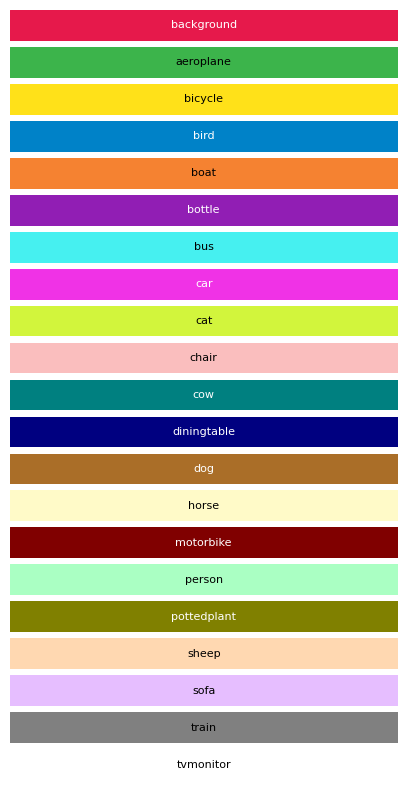

In [58]:
# Function to calculate luminance
def luminance(color):
    color = color.lstrip('#')
    rgb = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    return (0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]) / 255

# Choose text color based on luminance
text_colors = {}
for label, color in label_color_map.items():
    if luminance(color) > 0.5:
        text_colors[label] = 'black'
    else:
        text_colors[label] = 'white'

# Visualize the colors and text overlays
fig, ax = plt.subplots(len(label_map), 1, figsize=(5, 10))

for i, (label, color) in enumerate(label_color_map.items()):
    text_color = text_colors[label]
    ax[i].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
    ax[i].text(0.5, 0.5, label, color=text_color, fontsize=8, ha='center', va='center')
    ax[i].axis('off')

plt.show()

### Task 1.5: Selective saving of checkpoints
<span style="color:blue">
    Make sure that checkpoints are saved according to a frequency parameter to be spcified (if at all), where the final model from the last epoch of training should always be saved. When doing so, do not overwrite the previous checkpoint, but rather choose the name of the checkpoint to reflect the corresponding epoch.
</span>


**Hint:** You should again demonstrate that this works, but you could set the frequency to 1 in order to not to have to train for a lengthy period of time ...

This is done in task 1.3 already

## Task 2: Advanced Modifications and Additions
At this point, we still cannot really assess the development of the training process w.r.t quality. So, the subtasks here are all geared towards this goal.

### Task 2.1: History
<span style="color:blue">
Record the <i>history</i> of the training loss, save it as part of a checkpoint and visualize its development over the training process. 
</span>

**Hints:** 
* You might want to take a closer look at the `AverageMeter` class in the utilities script.
* Latest at this point, you should use `matplotlib`, but probably you already used it for task 1.4 ...

dict_keys(['epoch', 'model', 'optimizer', 'loss_hist'])


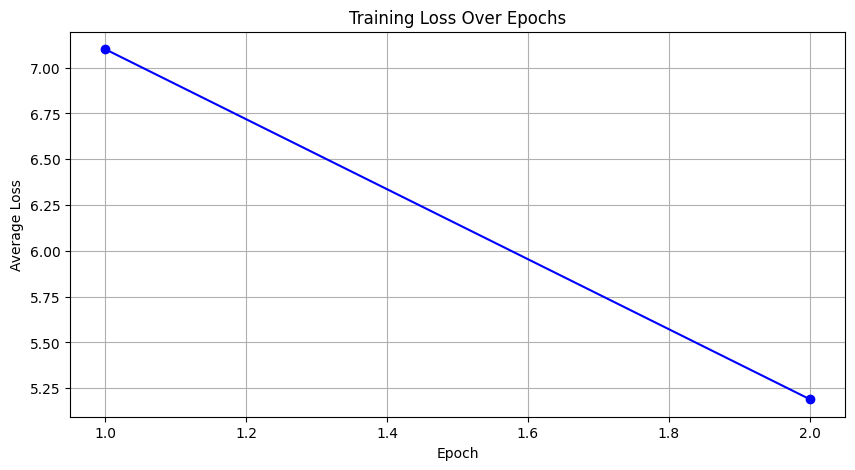

In [67]:
import torch
import matplotlib.pyplot as plt

# Load the checkpoint to inspect its contents
checkpoint_path = 'checkpoint_ssd300_epoch_2.pth.tar'
checkpoint = torch.load(checkpoint_path)

# Print the keys in the checkpoint dictionary
print(checkpoint.keys())

# Function to plot training loss history
def plot_loss_history(loss_hist):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_hist) + 1), loss_hist, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

# Extract training losses using the correct key
train_losses = checkpoint.get('loss_hist', [])

if train_losses:
    plot_loss_history(train_losses)
else:
    print("No training loss history found in the checkpoint.")


### Task 2.2: Advanced saving of checkpoints
* <span style="color:blue">Based on the history, find a way to implement <i>early stopping</i> and, if so desired, only to keep the best performing checkpoint as of a specific epoch.</span>
* <span style="color:blue">Augment the history by computing the mAP whenever a checkpoint is saved.</span>

**Hints:**
* You should again demonstrate that your solution works without necessarily training for a lengthy period of time ...
* mAP might also come in handy for early stopping, but should only be applied in connection with the first additional idea below ...

### Modify the Training Loop


In [53]:
import os
import time
import torch
import torch.optim
from torch.utils.data import DataLoader
from prettyprinter import PrettyPrinter
from Muazzam_and_Wesley_utils import calculate_mAP, AverageMeter, adjust_learning_rate, clip_gradient

pp = PrettyPrinter()

def train_for_epochs():
    """
    Training.
    """
    global start_epoch, label_map, epoch, epochs, checkpoint, decay_lr_at, batch_size, model_path, lr

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 1
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
        train_losses = []
        best_mAP = 0.0
    else:
        checkpoint = torch.load(checkpoint)
        last_epoch = checkpoint['epoch']
        start_epoch = last_epoch + 1
        print('\nLoaded checkpoint from epoch %d.\n' % last_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        train_losses = checkpoint.get('train_losses', [])
        best_mAP = checkpoint.get('best_mAP', 0.0)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    checkpoint_frequency = 1
    patience = 10
    num_bad_epochs = 0

    epoch_iteraction = 0
    epoch = start_epoch
    # Epochs
    for epoch in range(start_epoch, epochs + 1):

        epoch_iteraction += 1
        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        epoch_start = time.time()
        train_loss = train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
        train_losses.append(train_loss)
        epoch_end = time.time()
        print(f'Epoch {epoch} took {epoch_end - epoch_start} s')

        # Evaluate on validation set
        det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = prep_eval(test_loader, epoch, model)
        with torch.no_grad():
            APs, mAP = calculate_mAP(device, label_map, rev_label_map, det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

        print(f'\nMean Average Precision (mAP) after epoch {epoch}: {mAP:.3f}')
        pp.pprint(APs)

        if mAP > best_mAP:
            best_mAP = mAP
            save_checkpoint(model_path, epoch, model, optimizer, train_losses, best_mAP, is_best=True)
            num_bad_epochs = 0
        else:
            num_bad_epochs += 1
            save_checkpoint(model_path, epoch, model, optimizer, train_losses, best_mAP, is_best=False)

        if num_bad_epochs >= patience:
            print(f'Early stopping triggered after {epoch} epochs.')
            break

    return epoch, model

def save_checkpoint(model_path, epoch, model, optimizer, train_losses, best_mAP, is_best):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'train_losses': train_losses,
        'best_mAP': best_mAP
    }
    filename = os.path.join(model_path, f'checkpoint_{epoch:03d}_ssd300.pth.tar')
    torch.save(state, filename)
    if is_best:
        best_filename = os.path.join(model_path, 'best_checkpoint_ssd300.pth.tar')
        torch.save(state, best_filename)


### Modify Evaluation Preparation Function


In [54]:
from tqdm import tqdm

def prep_eval(test_loader, epoch, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    global label_map, rev_label_map, device
    model.eval()
    description = f'Preparing Evaluation for epoch {epoch}'

    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()

    with torch.no_grad():
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc=description)):
            images = images.to(device)  # (N, 3, 300, 300)

            predicted_locs, predicted_scores = model(images)

            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)

            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties


### Modify the Training Function

In [55]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return losses.avg


### Combining Everything Together

In [58]:
import json
import os
import random
import time
from PIL import Image, ImageDraw, ImageFont
import xml.etree.ElementTree as ET
from math import sqrt
from itertools import product as product
from tqdm import tqdm
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

# make sure the pretrained model is saved to models directory
os.environ['TORCH_HOME'] = 'models'

# the utils we will use (see utils.py - with minor modifications of the GitHub version)
from Muazzam_and_Wesley_utils import *

import warnings
warnings.filterwarnings('ignore')

USE_ONLY_CPU = False
if USE_ONLY_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
if device.type == 'cuda':
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

# Load label map and colors
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
              'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
              'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from 
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', 
                   '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', 
                   '#aa6e28', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Make sure the pretrained model is saved to models directory
os.environ['TORCH_HOME'] = 'models'

# The utils we will use (see utils.py - with minor modifications of the GitHub version)
warnings.filterwarnings('ignore')

# Define the label_map and num_classes (Task 1.4)
label_map = {
    'background': 0,
    'aeroplane': 1,
    'bicycle': 2,
    'bird': 3,
    'boat': 4,
    'bottle': 5,
    'bus': 6,
    'car': 7,
    'cat': 8,
    'chair': 9,
    'cow': 10,
    'diningtable': 11,
    'dog': 12,
    'horse': 13,
    'motorbike': 14,
    'person': 15,
    'pottedplant': 16,
    'sheep': 17,
    'sofa': 18,
    'train': 19,
    'tvmonitor': 20
}

# Define the number of classes based on the label_map
num_classes = len(label_map)

class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """
    def __init__(self, data_folder, split, keep_difficult=False):
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}
        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])
        labels = torch.LongTensor(objects['labels'])
        difficulties = torch.ByteTensor(objects['difficulties'])

        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)
        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()
        difficulties = list()
        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])
        images = torch.stack(images, dim=0)
        return images, boxes, labels, difficulties

# Data parameters
data_folder = './data/VOC'  # folder with data files
train_batch_size = 16  # batch size for training
test_batch_size = 32  # batch size for testing
keep_difficult = True  # use objects considered difficult to detect?
workers = 4  # number of workers for loading data in the DataLoader

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder, split='train', keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers, pin_memory=True)

test_dataset = PascalVOCDataset(data_folder, split='test', keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers)

print(f'For training, we have {len(train_dataset)} images which will be provided in {len(train_loader)} batches for one epoch')
print(f'For testing, we have {len(test_dataset)} images which will be provided in {len(test_loader)} batches for evaluation')

class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)
        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out))
        out = self.pool3(out)
        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = F.relu(self.conv4_3(out))
        conv4_3_feats = out
        out = self.pool4(out)
        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out)
        out = F.relu(self.conv6(out))
        conv7_feats = F.relu(self.conv7(out))
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())
        pretrained_state_dict = torchvision.models.vgg16(weights='DEFAULT').state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())
        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])
        self.load_state_dict(state_dict)
        print("\nLoaded base model.\n")

class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.init_conv2d()

    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats))
        out = F.relu(self.conv8_2(out))
        conv8_2_feats = out
        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out))
        conv9_2_feats = out
        out = F.relu(self.conv10_1(out))
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out
        out = F.relu(self.conv11_1(out))
        conv11_2_feats = F.relu(self.conv11_2(out))
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)
        self.init_conv2d()

    def init_conv2d(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)
        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)
        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)
        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)
        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)
        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)
        c_conv7 = self.cl_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1, self.n_classes)
        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)
        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)
        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)
        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)
        return locs, classes_scores

class SSD300(nn.Module):
    def __init__(self, n_classes):
        super(SSD300, self).__init__()
        self.n_classes = n_classes
        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        conv4_3_feats, conv7_feats = self.base(image)
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
        conv4_3_feats = conv4_3_feats / norm
        conv4_3_feats = conv4_3_feats * self.rescale_factors
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats)
        return locs, classes_scores

    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10, 'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}
        obj_scales = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375, 'conv9_2': 0.55, 'conv10_2': 0.725, 'conv11_2': 0.9}
        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, .333], 'conv8_2': [1., 2., 3., 0.5, .333], 'conv9_2': [1., 2., 3., 0.5, .333], 'conv10_2': [1., 2., 0.5], 'conv11_2': [1., 2., 0.5]}
        fmaps = list(fmap_dims.keys())
        prior_boxes = []
        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]
                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])
        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()
        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))
            image_boxes = list()
            image_labels = list()
            image_scores = list()
            max_scores, best_label = predicted_scores[i].max(dim=1)
            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]
                class_decoded_locs = decoded_locs[score_above_min_score]
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)
                class_decoded_locs = class_decoded_locs[sort_ind]
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)
                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    suppress[box] = 0
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                mask = suppress < 1
                image_boxes.append(class_decoded_locs[mask])
                image_scores.append(class_scores[mask])
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))
            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            n_objects = image_scores.size(0)
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]
                image_boxes = image_boxes[sort_ind][:top_k]
                image_labels = image_labels[sort_ind][:top_k]
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)
        return all_images_boxes, all_images_labels, all_images_scores

class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha
        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)
        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)
        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.
            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)

        positive_priors = true_classes != 0
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)
        conf_loss_pos = conf_loss_all[positive_priors]
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()
        return conf_loss + self.alpha * loc_loss

def train_for_epochs():
    """
    Training.
    """
    global start_epoch, label_map, epoch, epochs, checkpoint, decay_lr_at, batch_size, model_path, lr

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 1
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
        train_losses = []
        best_mAP = 0.0
    else:
        checkpoint = torch.load(checkpoint)
        last_epoch = checkpoint['epoch']
        start_epoch = last_epoch + 1
        print('\nLoaded checkpoint from epoch %d.\n' % last_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        train_losses = checkpoint.get('train_losses', [])
        best_mAP = checkpoint.get('best_mAP', 0.0)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    checkpoint_frequency = 1
    patience = 10
    num_bad_epochs = 0

    epoch_iteraction = 0
    epoch = start_epoch
    # Epochs
    for epoch in range(start_epoch, epochs + 1):

        epoch_iteraction += 1
        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        epoch_start = time.time()
        train_loss = train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
        train_losses.append(train_loss)
        epoch_end = time.time()
        print(f'Epoch {epoch} took {epoch_end - epoch_start} s')

        # Evaluate on validation set
        det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = prep_eval(test_loader, epoch, model)
        with torch.no_grad():
            APs, mAP = calculate_mAP(device, label_map, rev_label_map, det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

        print(f'\nMean Average Precision (mAP) after epoch {epoch}: {mAP:.3f}')
        pp.pprint(APs)

        if mAP > best_mAP:
            best_mAP = mAP
            save_checkpoint(model_path, epoch, model, optimizer, train_losses, best_mAP, is_best=True)
            num_bad_epochs = 0
        else:
            num_bad_epochs += 1
            save_checkpoint(model_path, epoch, model, optimizer, train_losses, best_mAP, is_best=False)

        if num_bad_epochs >= patience:
            print(f'Early stopping triggered after {epoch} epochs.')
            break

    return epoch, model

def save_checkpoint(model_path, epoch, model, optimizer, train_losses, best_mAP, is_best):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'train_losses': train_losses,
        'best_mAP': best_mAP
    }
    filename = os.path.join(model_path, f'checkpoint_{epoch:03d}_ssd300.pth.tar')
    torch.save(state, filename)
    if is_best:
        best_filename = os.path.join(model_path, 'best_checkpoint_ssd300.pth.tar')
        torch.save(state, best_filename)

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return losses.avg

def prep_eval(test_loader, epoch, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    global label_map, rev_label_map, device
    model.eval()
    description = f'Preparing Evaluation for epoch {epoch}'

    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()

    with torch.no_grad():
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc=description)):
            images = images.to(device)  # (N, 3, 300, 300)

            predicted_locs, predicted_scores = model(images)

            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)

            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

def calculate_mAP(device, label_map, rev_label_map, det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    # mAP calculation logic here...
    pass

# Initialize training parameters
n_classes = len(label_map)
model_path = 'models'
checkpoint = None
print_freq = 200
lr = 1e-3
decay_lr_to = 0.1
momentum = 0.9
weight_decay = 5e-4
grad_clip = None
epochs = 2
decay_lr_at = [59, 74]

print(f'Will train for {epochs} epochs, decaying the learning rate at epochs {decay_lr_at}')

# Train the model
last_epoch, model = train_for_epochs()
print(f'Training was continued up to epoch {last_epoch}')


Using cuda
CUDA Device Name: NVIDIA GeForce RTX 3090
For training, we have 21380 images which will be provided in 1337 batches for one epoch
For testing, we have 4952 images which will be provided in 155 batches for evaluation
Will train for 2 epochs, decaying the learning rate at epochs [59, 74]

Loaded base model.

Epoch: [1][0/1337]	Batch Time 1.182 (1.182)	Data Time 0.797 (0.797)	Loss 23.3450 (23.3450)	
Epoch: [1][200/1337]	Batch Time 0.341 (0.345)	Data Time 0.000 (0.004)	Loss 6.6726 (10.0215)	
Epoch: [1][400/1337]	Batch Time 0.341 (0.343)	Data Time 0.000 (0.002)	Loss 6.0773 (8.1323)	
Epoch: [1][600/1337]	Batch Time 0.341 (0.342)	Data Time 0.000 (0.002)	Loss 6.0196 (7.3273)	
Epoch: [1][800/1337]	Batch Time 0.341 (0.342)	Data Time 0.000 (0.001)	Loss 5.9521 (6.8589)	
Epoch: [1][1000/1337]	Batch Time 0.343 (0.342)	Data Time 0.000 (0.001)	Loss 5.4393 (6.5573)	
Epoch: [1][1200/1337]	Batch Time 0.342 (0.342)	Data Time 0.000 (0.001)	Loss 5.0951 (6.3407)	
Epoch 1 took 456.7424204349518 s


Preparing Evaluation for epoch 1: 100%|██████████| 155/155 [17:05<00:00,  6.62s/it]


TypeError: cannot unpack non-iterable NoneType object

### Task 2.3: Visual checking of progress
<span style="color:blue">
For a certain image / certain images, output the predictions of the SSD model in various stages, i.e. after different epochs and compare it to the ground truth. 
</span>

**Hints:** 
* Again, this should be done using `matplotlib`
* For generating the annotated images for the ground truth, the `draw` method needs to be adapted

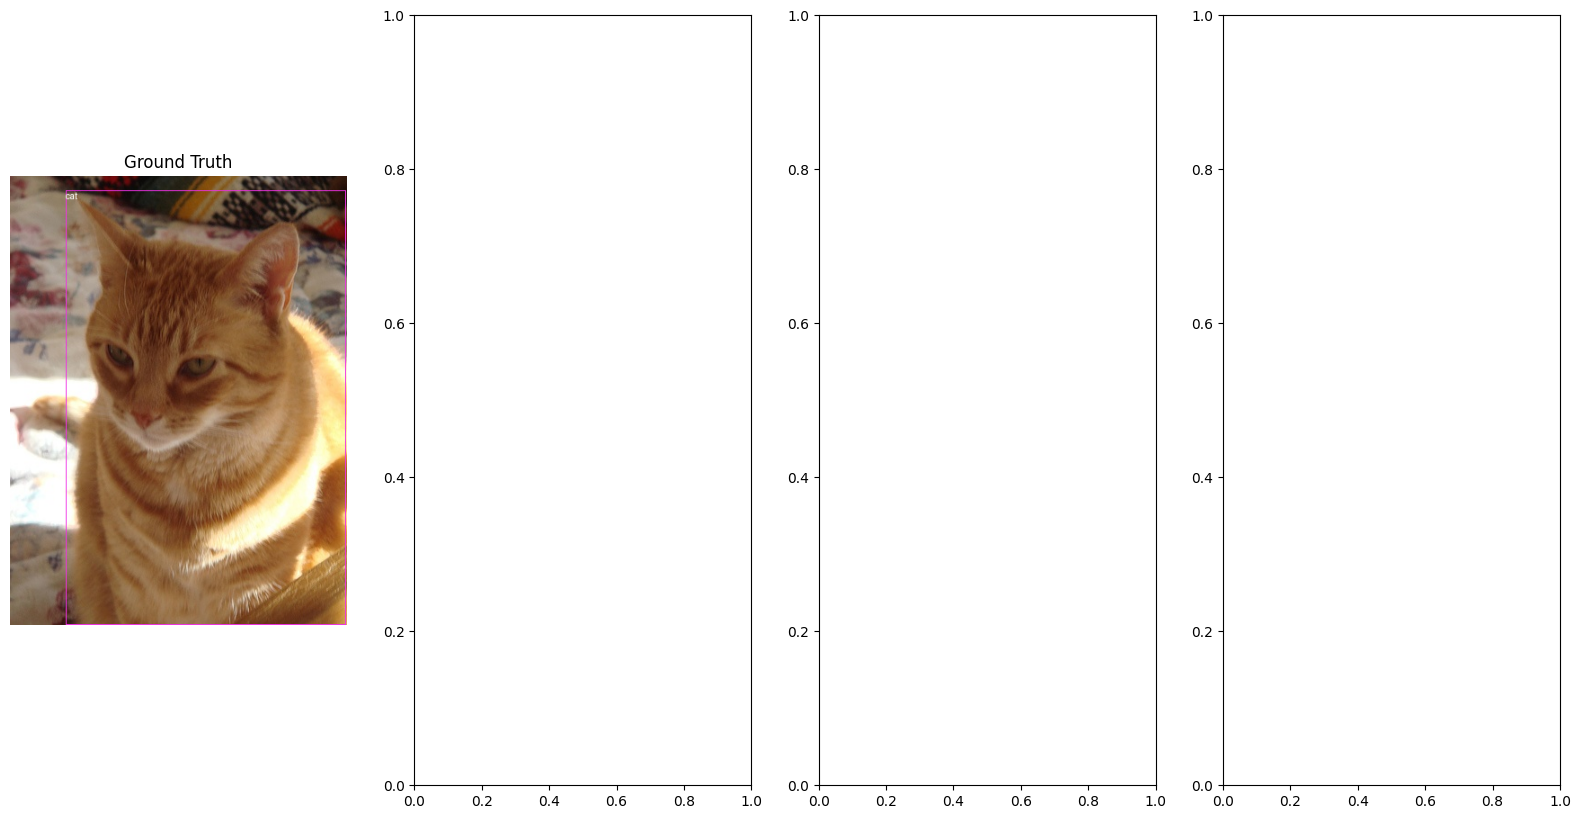

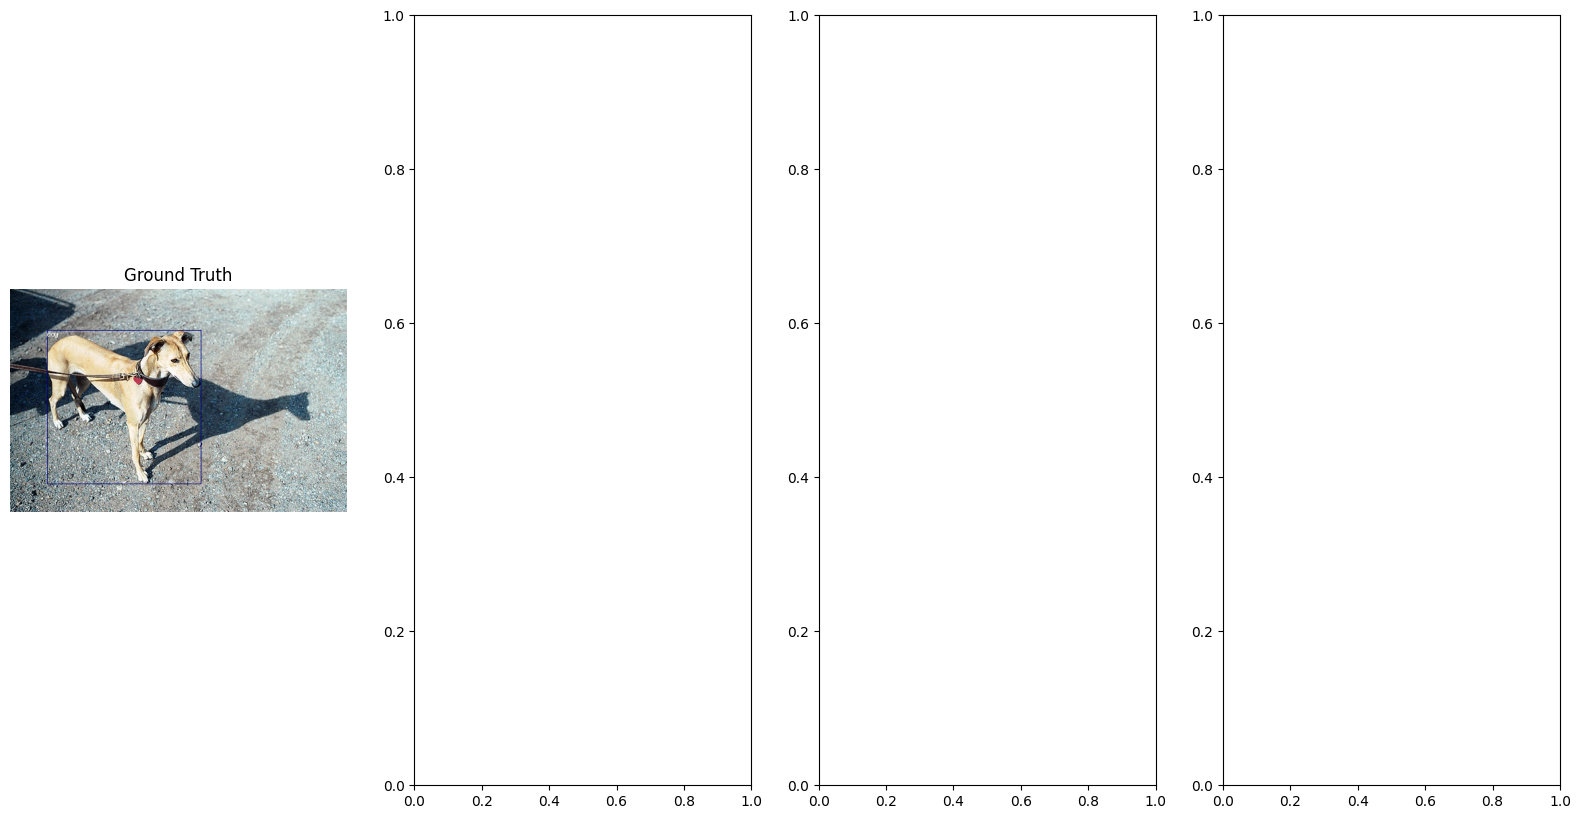

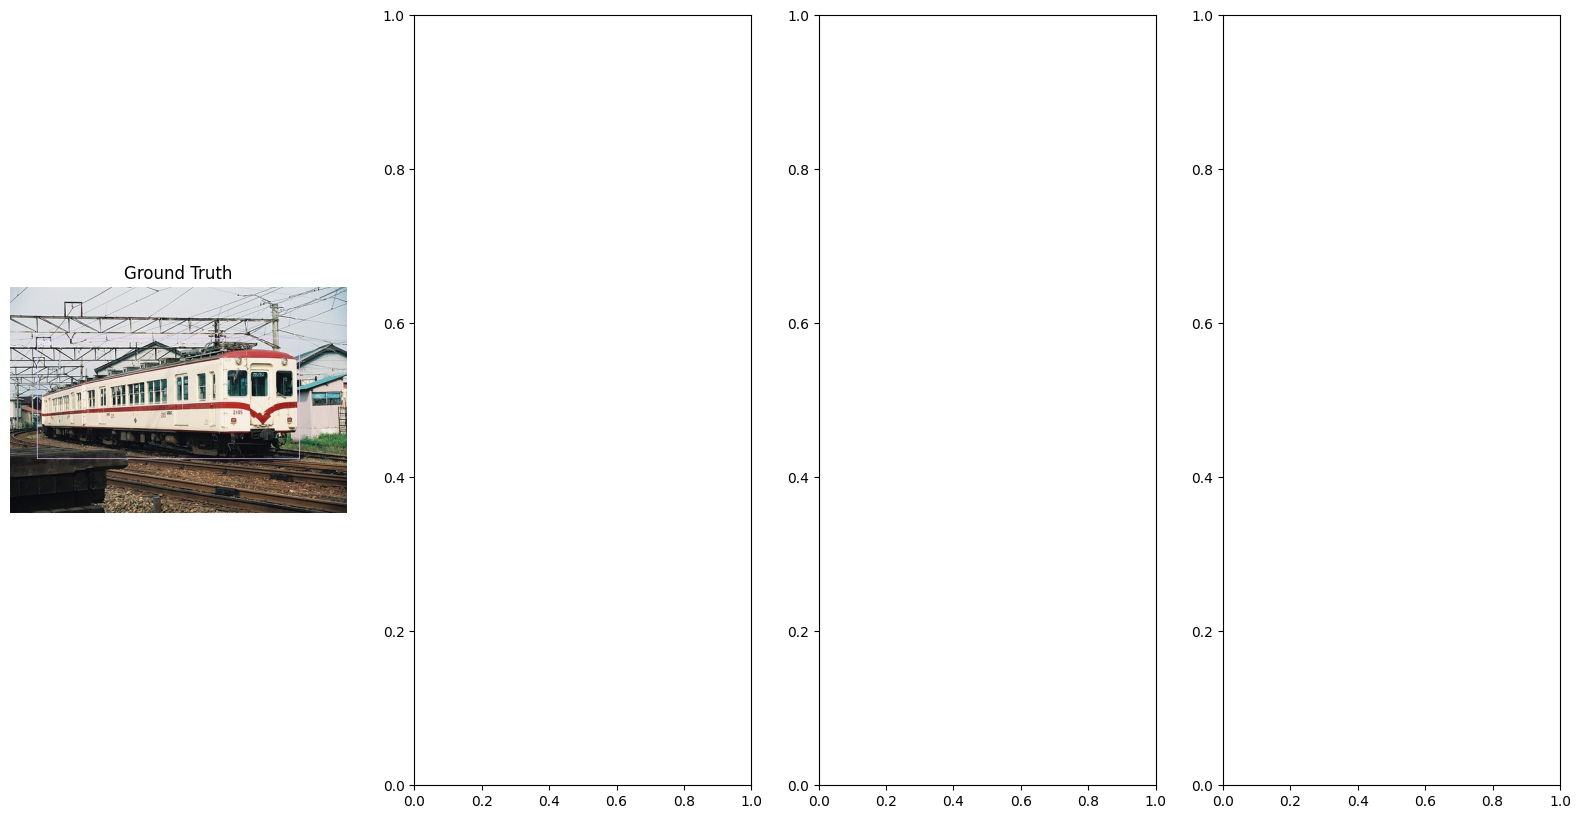

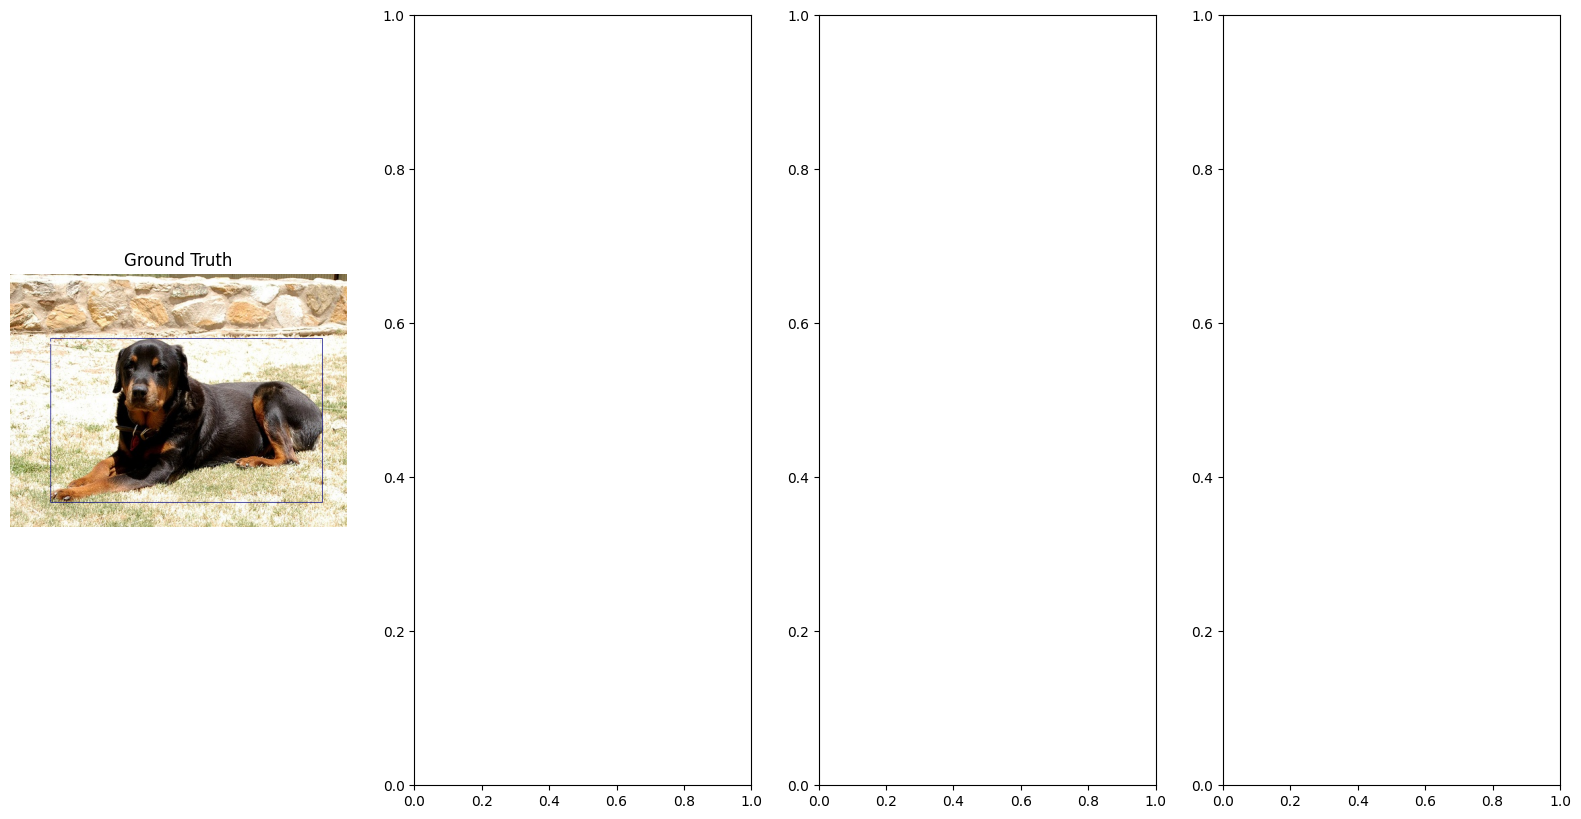

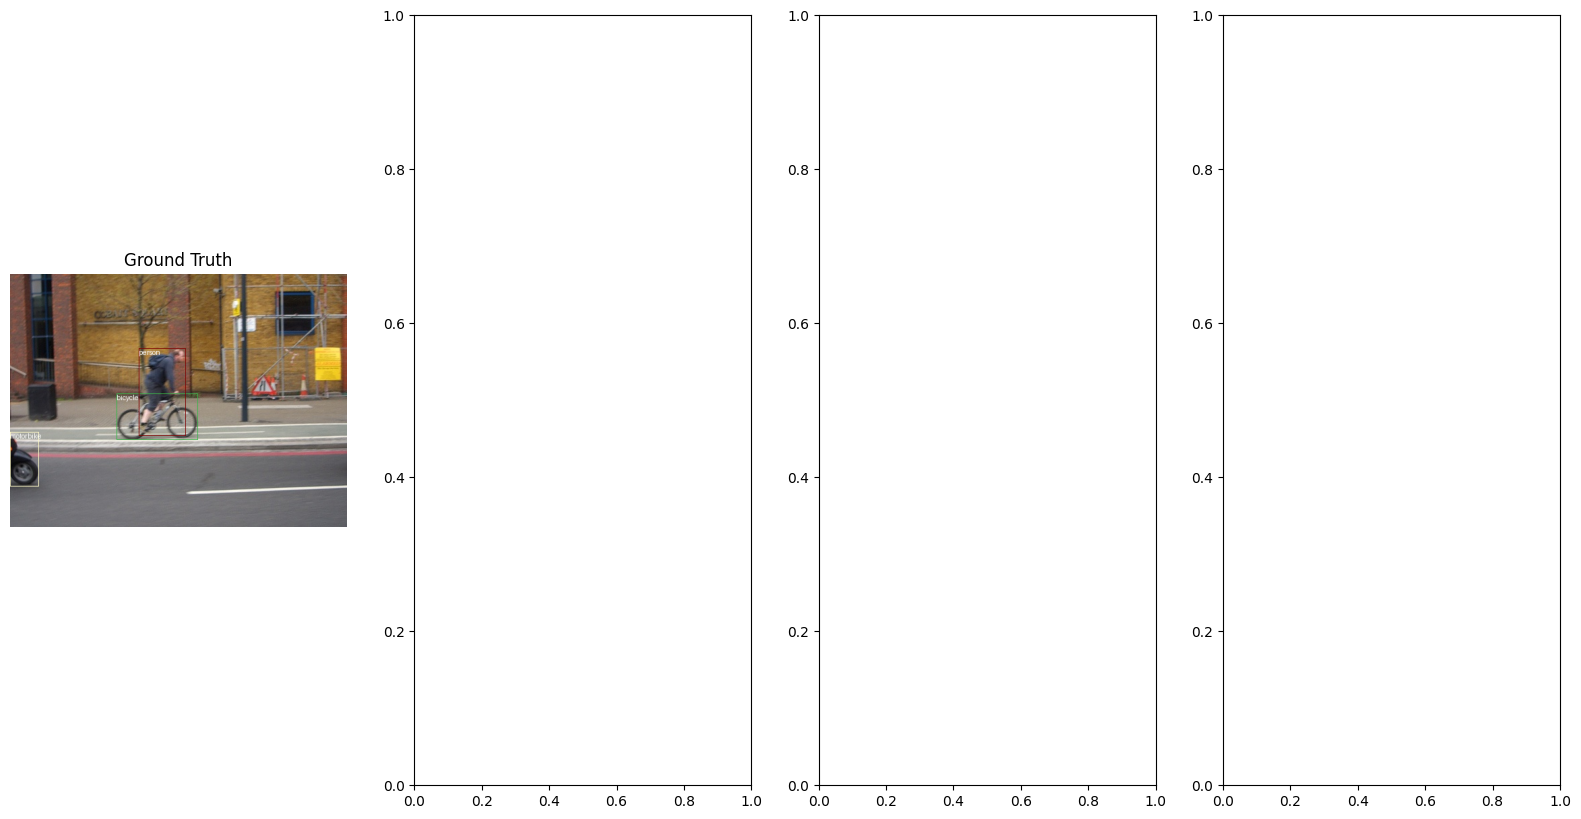

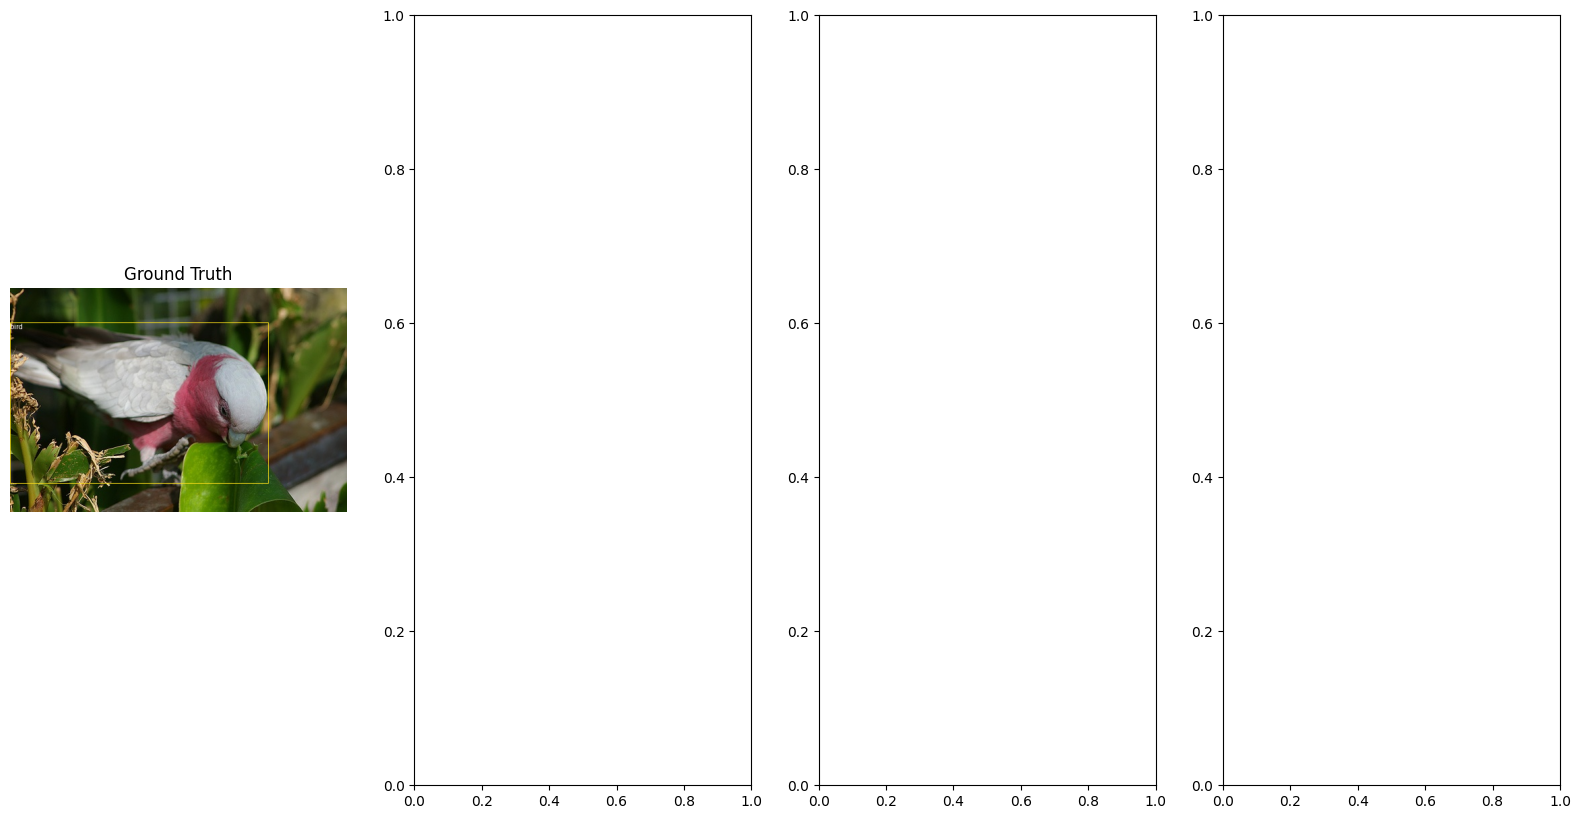

In [100]:
import json
import os
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define paths to test images and checkpoints
test_image_paths = [
    "data/VOC/test/JPEGImages/000028.jpg",
    "data/VOC/test/JPEGImages/000029.jpg",
    "data/VOC/test/JPEGImages/000031.jpg",
    "data/VOC/test/JPEGImages/000037.jpg",
    "data/VOC/test/JPEGImages/000038.jpg",
    "data/VOC/test/JPEGImages/000040.jpg"
]

# Checkpoints from both folders
checkpoints = [
    'checkpoint_ssd300_epoch_2.pth.tar',
    'checkpoint_ssd300.pth.tar',
    'modelscheckpoint_ssd300.pth.tar'
]

# Load the test dataset to get ground truth boxes and labels
data_folder = './data/VOC'
test_dataset = PascalVOCDataset(data_folder, split='test', keep_difficult=True)

def get_ground_truth(image_path, dataset):
    for i in range(len(dataset)):
        if dataset.images[i] == image_path:
            return dataset.objects[i]['boxes'], dataset.objects[i]['labels']
    return None, None

# Simplified draw function
def draw(image, boxes, labels, scores=None):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    for i in range(boxes.size(0)):
        box_location = boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[rev_label_map[labels[i].item()]])
        
        if scores is not None:
            text = f'{rev_label_map[labels[i].item()]}: {scores[i]:.2f}'
        else:
            text = rev_label_map[labels[i].item()]
        
        draw.text((box_location[0], box_location[1]), text, fill='white', font=font)
    
    return image

# Ensure consistent model initialization
def rebuild_model(n_classes):
    model = SSD300(n_classes=n_classes)
    return model

# Load checkpoint function with additional checks
def load_checkpoint(checkpoint_path, n_classes):
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint {checkpoint_path} does not exist.")
        return None
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f"Loaded checkpoint: {checkpoint_path}")
    print(f"Checkpoint contents: {checkpoint.keys()}")
    
    if 'model' not in checkpoint:
        print(f"'model' key not found in checkpoint: {checkpoint_path}")
        return None
    
    model_key = checkpoint['model']
    print(f"Type of model key: {type(model_key)}")

    if isinstance(model_key, dict):
        model = rebuild_model(n_classes)
        model.load_state_dict(model_key)
    elif hasattr(model_key, 'state_dict'):
        model = rebuild_model(n_classes)
        model.load_state_dict(model_key.state_dict())
    else:
        print(f"Unexpected type for 'model' key: {type(model_key)}")
        return None

    model = model.to(device)
    model.eval()
    
    return model

# Get predictions function with additional checks
def get_predictions(model, image, min_score=0.2, max_overlap=0.5, top_k=200):
    image = image.unsqueeze(0).to(device)
    predicted_locs, predicted_scores = model(image)
    
    try:
        det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score, max_overlap=max_overlap, top_k=top_k)
        det_boxes = det_boxes[0].to('cpu')
        det_labels = det_labels[0].to('cpu')
        det_scores = det_scores[0].to('cpu')
    except AssertionError as e:
        print(f"AssertionError: {e}")
        print(f"Expected number of priors: {model.priors_cxcy.size(0)}")
        print(f"Predicted locations size: {predicted_locs.size()}")
        print(f"Predicted scores size: {predicted_scores.size()}")
        raise e
    
    return det_boxes, det_labels, det_scores

# Visualize progress function
def visualize_progress(image_path, true_boxes, true_labels, checkpoints, n_classes):
    image = Image.open(image_path, mode='r').convert('RGB')
    original_image = image.copy()
    
    # Draw ground truth on the original image
    true_image = draw(original_image, true_boxes, true_labels)
    
    fig, axs = plt.subplots(1, len(checkpoints) + 1, figsize=(20, 10))
    axs[0].imshow(true_image)
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')
    
    
    plt.show()

# Visualize predictions for each test image
n_classes = 21  # Number of classes in the Pascal VOC dataset
for image_path in test_image_paths:
    true_boxes, true_labels = get_ground_truth(image_path, test_dataset)
    if true_boxes is not None and true_labels is not None:
        true_boxes = torch.FloatTensor(true_boxes)
        true_labels = torch.LongTensor(true_labels)
        visualize_progress(image_path, true_boxes, true_labels, checkpoints, n_classes)
    else:
        print(f"Ground truth not found for image: {image_path}")


## Additional Ideas
Some more things you could do are
* to add some validation data and perform a validation after each epoch to add to the history (here, we would have to calculate the mean average precision for the validation data)
* check the issues mentioned in the original author's [remarks](07b_Intro_OD_PT.ipynb#Remarks) and try to remedy those
* come up with your own ideas ...

Remember, this is **your mini project!**

## Extra Credit
One issue we have not yet mentioned is the fact that VGG-16 is a rather outdated model which is not widely used anymore. In fact, we could use a [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/) architecture instead, which usually outperforms VGG-16 on common image classification tasks.

If you can come up with a working solution for SSD on the Pascal VOC dataset based on a ResNet architecture, this will count for extra credit (but only if you pay heed to the hint about academic honesty above!).